In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

z_dim = 100

In [3]:
def build_generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape(img_shape))
    return model

In [4]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [5]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [6]:
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

generator = build_generator(img_shape, z_dim)

discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [7]:
losses = []
accuracies = []
iteration_checkpoints = []

In [8]:
def train(iterations, batch_size, sample_interval):
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train / 127.5 -1.0
    X_train = np.expand_dims(X_train, axis=3)

    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        g_loss = gan.train_on_batch(z, real)

        if (iteration+1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(1000.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration + 1, d_loss, accuracy, g_loss))

            sample_images(generator)

In [9]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    gen_imgs = generator.predict(z)

    gen_imgs = 0.5 * gen_imgs * 0.5

    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(4, 4), sharey=True, sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

1000 [D loss: 0.057871, acc.: 1.00%] [G loss: 3.502539]


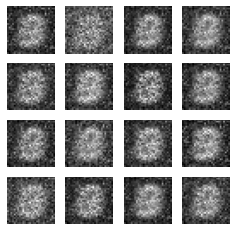

2000 [D loss: 0.033473, acc.: 0.99%] [G loss: 5.170727]


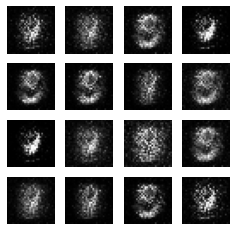

3000 [D loss: 0.113530, acc.: 0.95%] [G loss: 4.612126]


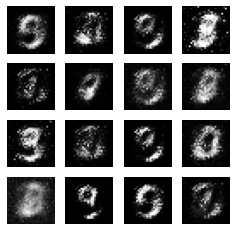

4000 [D loss: 0.136649, acc.: 0.94%] [G loss: 5.399544]


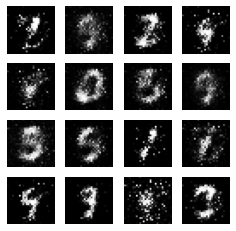

5000 [D loss: 0.150405, acc.: 0.92%] [G loss: 5.885922]


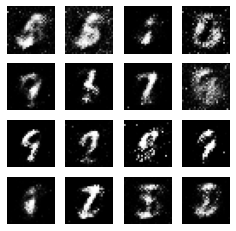

6000 [D loss: 0.129601, acc.: 0.96%] [G loss: 5.194114]


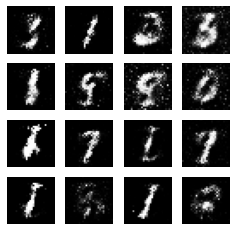

7000 [D loss: 0.285061, acc.: 0.90%] [G loss: 5.221621]


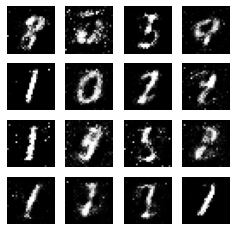

8000 [D loss: 0.343244, acc.: 0.87%] [G loss: 4.198345]


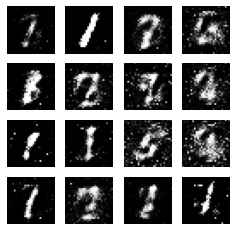

9000 [D loss: 0.315256, acc.: 0.86%] [G loss: 3.954979]


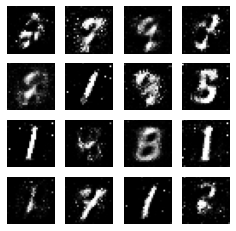

10000 [D loss: 0.371447, acc.: 0.86%] [G loss: 3.695082]


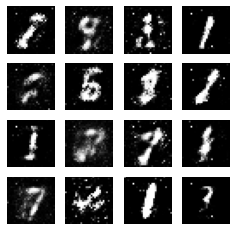

11000 [D loss: 0.445815, acc.: 0.81%] [G loss: 3.262441]


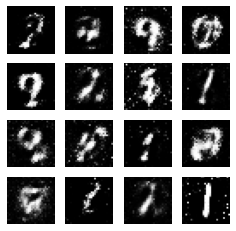

12000 [D loss: 0.431689, acc.: 0.82%] [G loss: 3.209692]


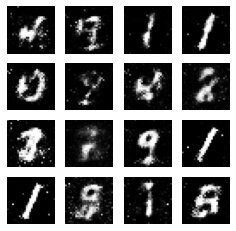

13000 [D loss: 0.511677, acc.: 0.77%] [G loss: 3.041159]


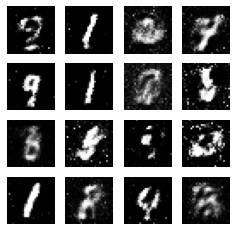

14000 [D loss: 0.215156, acc.: 0.91%] [G loss: 3.678200]


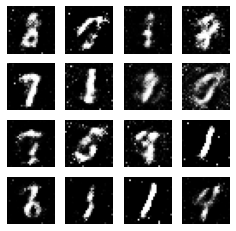

15000 [D loss: 0.238106, acc.: 0.91%] [G loss: 4.141434]


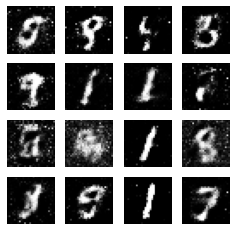

16000 [D loss: 0.323929, acc.: 0.87%] [G loss: 3.262321]


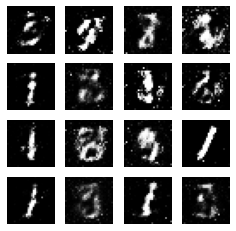

17000 [D loss: 0.333121, acc.: 0.86%] [G loss: 3.282305]


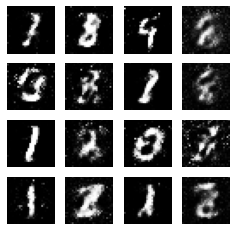

18000 [D loss: 0.263647, acc.: 0.89%] [G loss: 3.202816]


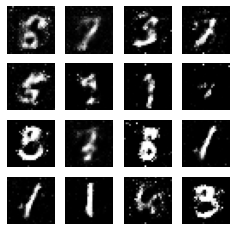

19000 [D loss: 0.211399, acc.: 0.90%] [G loss: 3.127586]


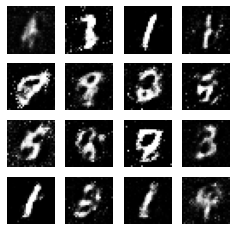

20000 [D loss: 0.311946, acc.: 0.86%] [G loss: 2.983168]


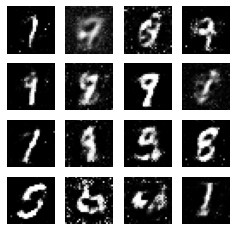

In [10]:
iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)